# Bayesian Optimization

Goal is to find the $x \in \mathbb R^d$ corresponding to the global maximum (or minimum) of a function $f:\mathbb R^d \mapsto \mathbb R$. Workflow

+ Select most promissing point $z \in \mathbb R^d$ that you think that it might be the global maximum
+ Query $z$, i.e, observe $f(z)$
+ Update your beliefs



### Acqusition Function

An acquisition function determines a next point to be queried. A next point is determined based on its probability of improvement over the current $\textrm{max} f(x^+)$:

$$ x_{t+1} = \textrm{argmax}_x \mathbb P (f(x)) \geq  \mathbb P (f(x^+) + \epsilon) $$
where

$$ x^+ = \textrm{argmax}_{x_i \in x_{1:t}} f(x_i)$$


Assumed that we are using Gaussian Process Regression as a surrogate model, the next point to be quared can be found as


$$ x^+ = \textrm{argmax} \Phi \Big( \frac{\mu_t (x) - f(x^+) - \epsilon}{\sigma_t (x)} \Big) $$



In [4]:
# pyro EXAMPLE
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import torch
import torch.autograd as autograd
import torch.optim as optim
from torch.distributions import constraints, transform_to

import pyro
import pyro.contrib.gp as gp

assert pyro.__version__.startswith('1.7.0')
pyro.set_rng_seed(1)

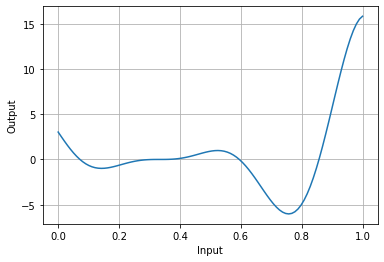

In [12]:
def f(x):
    return (6 * x - 2)**2 * torch.sin(12 * x - 4)

x = torch.linspace(0, 1)
plt.plot(x.numpy(), f(x).numpy(),label='True Function')
plt.ylabel('Output')
plt.xlabel('Input')
plt.grid()
plt.show()

In [20]:
# initialize the model with four input points: 0.0, 0.33, 0.66, 1.0
X = torch.tensor([0.0, 0.33, 0.66, 1.0])
y = f(X)

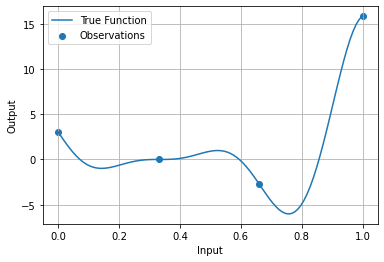

In [21]:
x = torch.linspace(0, 1)
plt.plot(x.numpy(), f(x).numpy(),label='True Function')
plt.scatter(X.numpy(),y.numpy(),label='Observations')
plt.ylabel('Output')
plt.xlabel('Input')
plt.legend()
plt.grid()
plt.show()

In [22]:
gpmodel = gp.models.GPRegression(X, y, 
                                 gp.kernels.Matern52(input_dim=1),
                                 noise=torch.tensor(0.1), 
                                 jitter=1.0e-4)
# Estimate surrpogate model parameters via Adam
optimizer = torch.optim.Adam(gpmodel.parameters(), lr=0.001)
loss=gp.util.train(gpmodel, optimizer)

In [27]:
gpmodel.X

tensor([0.0000, 0.3300, 0.6600, 1.0000])

In [30]:
def lower_confidence_bound(x, kappa=2):
    mu, variance = gpmodel(x, full_cov=False, noiseless=False)
    sigma = variance.sqrt()
    return mu - kappa * sigma

def find_a_candidate(x_init, lower_bound=0, upper_bound=1):
    # transform x to an unconstrained domain
    constraint = constraints.interval(lower_bound, upper_bound)
    unconstrained_x_init = transform_to(constraint).inv(x_init)
    unconstrained_x = unconstrained_x_init.clone().detach().requires_grad_(True)
    minimizer = optim.LBFGS([unconstrained_x], line_search_fn='strong_wolfe')

    def closure():
        minimizer.zero_grad()
        x = transform_to(constraint)(unconstrained_x)
        y = lower_confidence_bound(x)
        autograd.backward(unconstrained_x, autograd.grad(y, unconstrained_x))
        return y

    minimizer.step(closure)
    # after finding a candidate in the unconstrained domain,
    # convert it back to original domain.
    x = transform_to(constraint)(unconstrained_x)
    return x.detach()

def next_x(lower_bound=0, upper_bound=1, num_candidates=5):
    candidates = []
    values = []
    # (1) Get the lastly observed point
    x_init = gpmodel.X[-1:]
    for i in range(num_candidates):
        
        # (2) Given (1) and bounds, find a candidate point to be queried
        x = find_a_candidate(x_init, lower_bound, upper_bound)

        # (3) Compute lower confidence bound
        y = lower_confidence_bound(x)
        
        # (4) Store candidate point to be queried along with lower confidence bound
        candidates.append(x)
        values.append(y)
        # (5) Update the lastly observed point
        x_init = x.new_empty(1).uniform_(lower_bound, upper_bound)

    argmin = torch.min(torch.cat(values), dim=0)[1].item()
    # (6) Return a point whose output we are most uncertain of
    return candidates[argmin]

In [31]:
xmin = next_x()

In [32]:
xmin

tensor([0.5230])

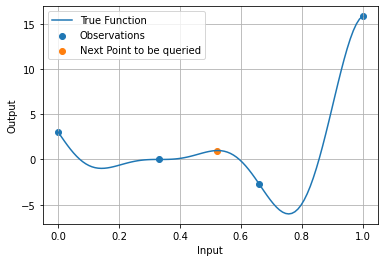

In [34]:
x = torch.linspace(0, 1)
plt.plot(x.numpy(), f(x).numpy(),label='True Function')
plt.scatter(X.numpy(),y.numpy(),label='Observations')
plt.scatter(xmin.numpy(),f(xmin).numpy(),label='Next Point to be queried')
plt.ylabel('Output')
plt.xlabel('Input')
plt.legend()
plt.grid()
plt.show()

In [35]:
def update_posterior(x_new):
    y = f(x_new) # evaluate f at new point.
    X = torch.cat([gpmodel.X, x_new]) # incorporate new evaluation
    y = torch.cat([gpmodel.y, y])
    gpmodel.set_data(X, y)
    # optimize the GP hyperparameters using Adam with lr=0.001
    optimizer = torch.optim.Adam(gpmodel.parameters(), lr=0.001)
    gp.util.train(gpmodel, optimizer)

# Update our beliefs
update_posterior(xmin)

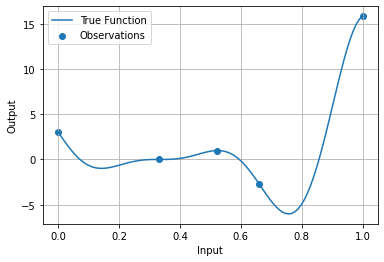

In [40]:
x = torch.linspace(0, 1)
plt.plot(x.numpy(), f(x).numpy(),label='True Function')
plt.scatter(gpmodel.X.numpy(),gpmodel.y.numpy(),label='Observations')
plt.ylabel('Output')
plt.xlabel('Input')
plt.legend()
plt.grid()
plt.show()

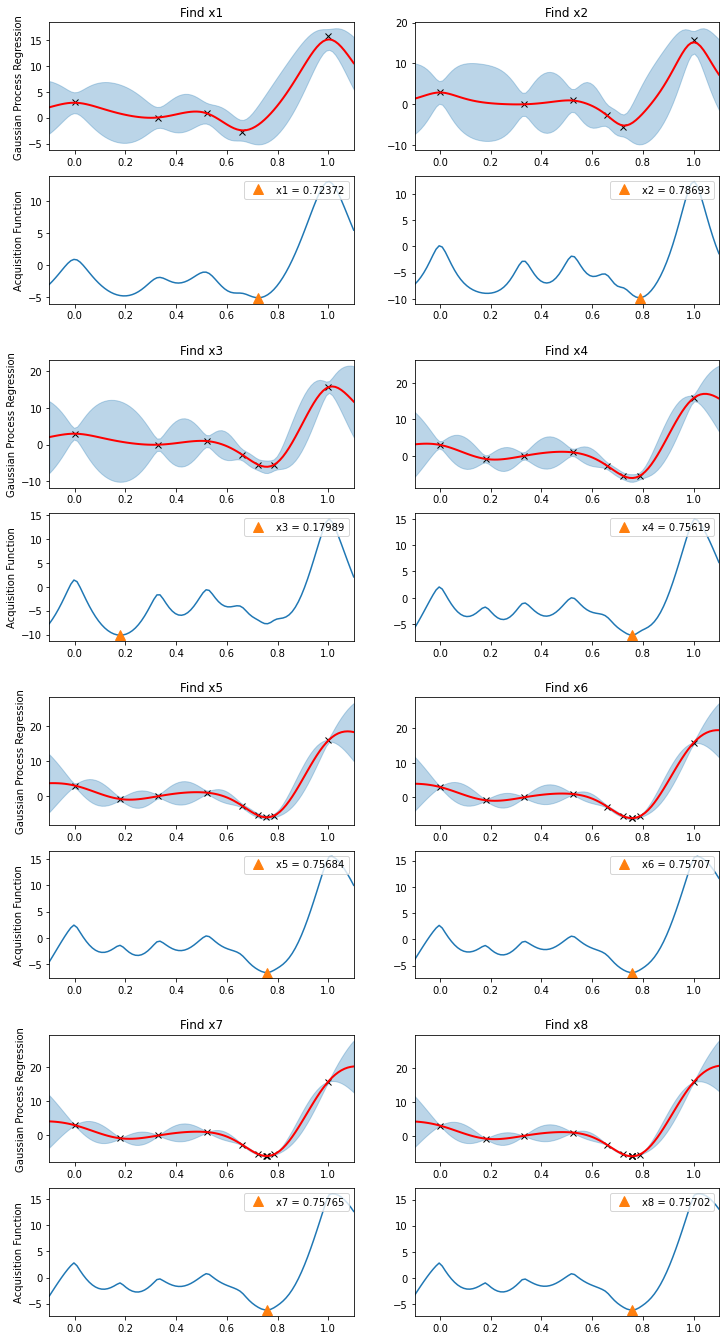

In [41]:
def plot(gs, xmin, xlabel=None, with_title=True):
    xlabel = "xmin" if xlabel is None else "x{}".format(xlabel)
    Xnew = torch.linspace(-0.1, 1.1)
    ax1 = plt.subplot(gs[0])
    ax1.plot(gpmodel.X.numpy(), gpmodel.y.numpy(), "kx")  # plot all observed data
    with torch.no_grad():
        loc, var = gpmodel(Xnew, full_cov=False, noiseless=False)
        sd = var.sqrt()
        ax1.plot(Xnew.numpy(), loc.numpy(), "r", lw=2)  # plot predictive mean
        ax1.fill_between(Xnew.numpy(), loc.numpy() - 2*sd.numpy(), loc.numpy() + 2*sd.numpy(),
                         color="C0", alpha=0.3)  # plot uncertainty intervals
    ax1.set_xlim(-0.1, 1.1)
    ax1.set_title("Find {}".format(xlabel))
    if with_title:
        ax1.set_ylabel("Gaussian Process Regression")

    ax2 = plt.subplot(gs[1])
    with torch.no_grad():
        # plot the acquisition function
        ax2.plot(Xnew.numpy(), lower_confidence_bound(Xnew).numpy())
        # plot the new candidate point
        ax2.plot(xmin.numpy(), lower_confidence_bound(xmin).numpy(), "^", markersize=10,
                 label="{} = {:.5f}".format(xlabel, xmin.item()))
    ax2.set_xlim(-0.1, 1.1)
    if with_title:
        ax2.set_ylabel("Acquisition Function")
    ax2.legend(loc=1)
    
    
plt.figure(figsize=(12, 30))
outer_gs = gridspec.GridSpec(5, 2)
optimizer = torch.optim.Adam(gpmodel.parameters(), lr=0.001)
gp.util.train(gpmodel, optimizer)
for i in range(8):
    xmin = next_x()
    gs = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=outer_gs[i])
    plot(gs, xmin, xlabel=i+1, with_title=(i % 2 == 0))
    update_posterior(xmin)
plt.show()